# Air Quality — In‑Depth Correlation Analysis
This notebook focuses on **meteorological variables (T, RH, AH)** versus **pollutants** (CO, NOx, NO2, C6H6, NMHC). It provides Pearson/Spearman matrices, partial correlations, diurnal (hour-of-day) correlations, deseasonalized correlations, lagged cross-correlations, and pairwise scatter plots with binned trend overlays.

**Notes**: The loader handles the UCI CSV format (semicolon; decimal commas; time like `18.00.00`). Sentinel `-200` values are treated as missing.

In [3]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt

def safe_display(name: str, dataframe: pd.DataFrame, head_n: int = 20):
    try:
        from ace_tools import display_dataframe_to_user
        display_dataframe_to_user(name, dataframe)
    except Exception:
        print(f"\n=== {name} ===")
        try:
            from IPython.display import display
            display(dataframe.head(head_n))
        except Exception:
            print(dataframe.head(head_n).to_string())

def robust_read_air_quality(csv_path: str) -> pd.DataFrame:
    import pandas as pd, numpy as np
    df = None
    for kwargs in [
        dict(sep=';', decimal=',', engine='python', encoding='utf-8', na_values=[-200, 'NaN', 'NA']),
        dict(sep=';', decimal=',', engine='python', encoding='latin-1', na_values=[-200, 'NaN', 'NA']),
        dict(sep=None, engine='python', encoding='utf-8', na_values=[-200, 'NaN', 'NA']),
        dict(sep=None, engine='python', encoding='latin-1', na_values=[-200, 'NaN', 'NA']),
    ]:
        try:
            df = pd.read_csv(csv_path, **kwargs)
            break
        except Exception:
            df = None
    if df is None:
        raise RuntimeError("Could not read CSV at " + csv_path)

    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed")]
    df.columns = [c.strip() for c in df.columns]

    time_cols = [c for c in df.columns if c.lower().startswith('time')]
    if len(time_cols) > 0:
        tcol = time_cols[0]
        df[tcol] = df[tcol].astype(str).str.replace('.', ':', regex=False)

    date_cols = [c for c in df.columns if c.lower().startswith('date')]
    if date_cols and time_cols:
        dt = pd.to_datetime(
            df[date_cols[0]].astype(str).str.strip() + ' ' + df[time_cols[0]].astype(str).str.strip(),
            dayfirst=True, errors='coerce'
        )
    elif date_cols:
        dt = pd.to_datetime(df[date_cols[0]].astype(str), dayfirst=True, errors='coerce')
    else:
        dt = pd.to_datetime(df.iloc[:, 0].astype(str) + ' ' + df.iloc[:, 1].astype(str),
                            dayfirst=True, errors='coerce')
    df.insert(0, 'Datetime', dt)
    df = df.dropna(subset=['Datetime']).sort_values('Datetime').set_index('Datetime')

    non_numeric = set(date_cols + time_cols)
    for col in df.columns:
        if col not in non_numeric:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].replace(-200, np.nan)
    df = df.dropna(axis=1, how='all')
    return df

CSV_PATH = r"data/AirQualityUCI.csv"
df = robust_read_air_quality(CSV_PATH)

pollutant_cols = [c for c in ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)'] if c in df.columns]
met_cols       = [c for c in ['T', 'RH', 'AH'] if c in df.columns]

print(f"Loaded: {len(df):,} rows, {df.shape[1]} columns; range: {df.index.min()} → {df.index.max()}")
safe_display("Detected pollutants / meteorological variables",
             pd.DataFrame({'pollutants':['; '.join(pollutant_cols)], 'meteorology':['; '.join(met_cols)]}))


Loaded: 9,357 rows, 15 columns; range: 2004-03-10 18:00:00 → 2005-04-04 14:00:00

=== Detected pollutants / meteorological variables ===


,pollutants,meteorology
0,CO(GT); NMHC(GT); C6H6(GT); NOx(GT); NO2(GT),T; RH; AH


In [5]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt

def pairwise_clean(x: pd.Series, y: pd.Series):
    m = ~(x.isna() | y.isna())
    return x[m].astype(float).values, y[m].astype(float).values

def corr_coef(x, y, method='pearson'):
    if len(x) < 3 or len(y) < 3:
        return np.nan
    if method == 'pearson':
        return float(np.corrcoef(x, y)[0,1])
    elif method == 'spearman':
        xr = pd.Series(x).rank(method='average').values
        yr = pd.Series(y).rank(method='average').values
        return float(np.corrcoef(xr, yr)[0,1])
    else:
        raise ValueError("Unsupported method")

def fisher_ci(r, n, alpha=0.05):
    if np.isnan(r) or n < 4:
        return (np.nan, np.nan)
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1 / np.sqrt(n - 3)
    z_lo = z - 1.96*se
    z_hi = z + 1.96*se
    return (np.tanh(z_lo), np.tanh(z_hi))

def partial_corr_xy_given_Z(df_in, x, y, Z):
    cols = [x, y] + Z
    d = df_in[cols].dropna()
    if d.shape[0] < len(cols) + 3:
        return np.nan
    X = d[Z].values
    X = np.c_[np.ones(len(X)), X]
    beta_x, *_ = np.linalg.lstsq(X, d[x].values, rcond=None)
    e_x = d[x].values - X @ beta_x
    beta_y, *_ = np.linalg.lstsq(X, d[y].values, rcond=None)
    e_y = d[y].values - X @ beta_y
    return float(np.corrcoef(e_x, e_y)[0,1])

def hourly_corr(x: pd.Series, y: pd.Series, method='pearson'):
    out = {}
    for h in range(24):
        xv = x[x.index.hour==h]
        yv = y[y.index.hour==h]
        a, b = pairwise_clean(xv, yv)
        out[h] = corr_coef(a, b, method=method)
    return pd.Series(out).sort_index()

def deseason_hour_month(s: pd.Series):
    s1 = s - s.groupby(s.index.hour).transform('mean')
    s2 = s1 - s1.groupby(s1.index.month).transform('mean')
    return s2

def crosscorr_series(x: pd.Series, y: pd.Series, max_lag=72):
    lags = np.arange(-max_lag, max_lag+1)
    vals = []
    for lag in lags:
        if lag > 0:
            a = x.iloc[:-lag]; b = y.iloc[lag:]
        elif lag < 0:
            a = x.iloc[-lag:]; b = y.iloc[:lag]
        else:
            a = x; b = y
        ab = pd.concat([a, b], axis=1).dropna()
        vals.append(np.corrcoef(ab.iloc[:,0], ab.iloc[:,1])[0,1] if ab.shape[0]>=10 else np.nan)
    return lags, np.array(vals, dtype=float)

def build_corr_matrix(df, mets, pols, method='pearson'):
    mat = pd.DataFrame(index=mets, columns=pols, dtype=float)
    for m in mets:
        for p in pols:
            a, b = pairwise_clean(df[m], df[p])
            mat.loc[m, p] = corr_coef(a, b, method=method)
    return mat



=== Pearson correlation (met × pollutants) ===


,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
T,0.022,0.392,0.199,-0.270,-0.187
RH,0.049,-0.191,-0.062,0.221,-0.092
AH,0.049,0.270,0.168,-0.149,-0.335



=== Spearman correlation (met × pollutants) ===


,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
T,0.069,0.506,0.276,-0.283,-0.190
RH,-0.006,-0.278,-0.122,0.182,-0.121
AH,0.053,0.293,0.192,-0.190,-0.323


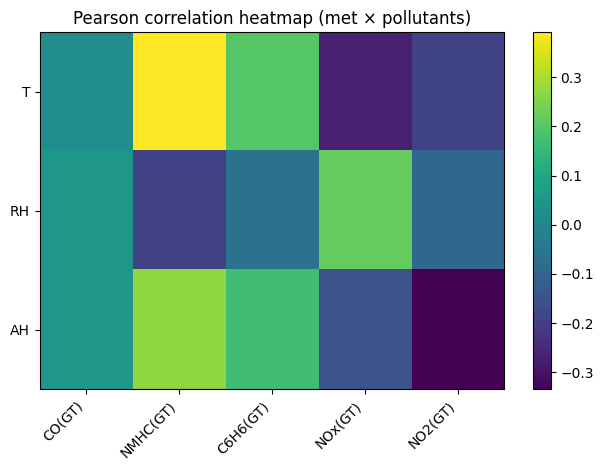

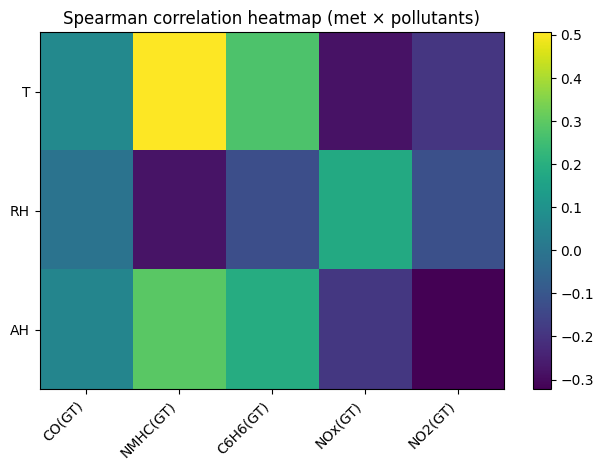

In [6]:

# 1) Pearson & Spearman (meteorology × pollutants)
pearson_mat = build_corr_matrix(df, met_cols, pollutant_cols, method='pearson')
spearman_mat = build_corr_matrix(df, met_cols, pollutant_cols, method='spearman')

safe_display("Pearson correlation (met × pollutants)", pearson_mat.round(3))
safe_display("Spearman correlation (met × pollutants)", spearman_mat.round(3))

plt.figure()
plt.imshow(pearson_mat.values, interpolation='nearest', aspect='auto')
plt.xticks(range(len(pollutant_cols)), pollutant_cols, rotation=45, ha='right')
plt.yticks(range(len(met_cols)), met_cols)
plt.title('Pearson correlation heatmap (met × pollutants)')
plt.colorbar(); plt.tight_layout(); plt.show()

plt.figure()
plt.imshow(spearman_mat.values, interpolation='nearest', aspect='auto')
plt.xticks(range(len(pollutant_cols)), pollutant_cols, rotation=45, ha='right')
plt.yticks(range(len(met_cols)), met_cols)
plt.title('Spearman correlation heatmap (met × pollutants)')
plt.colorbar(); plt.tight_layout(); plt.show()


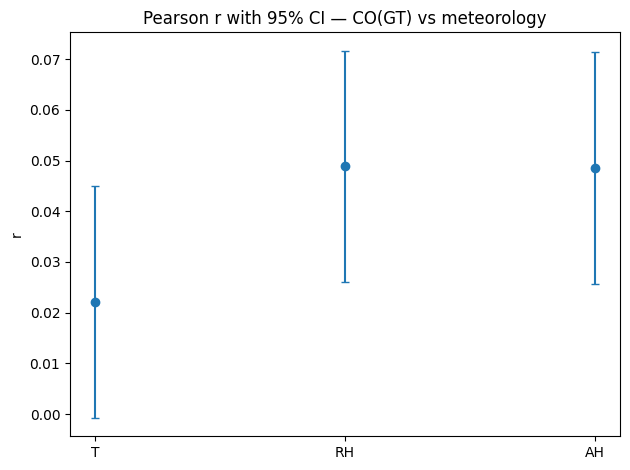

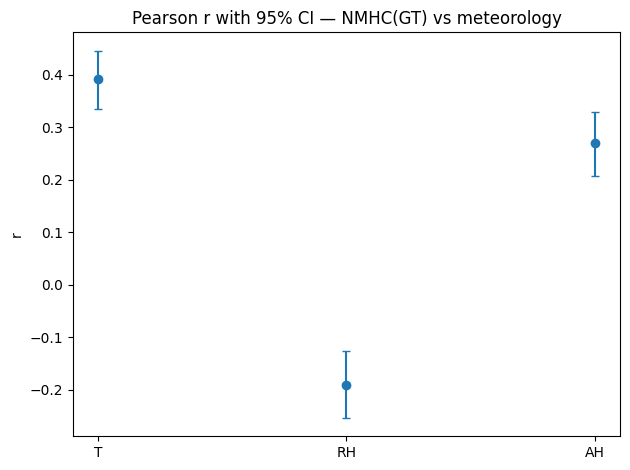

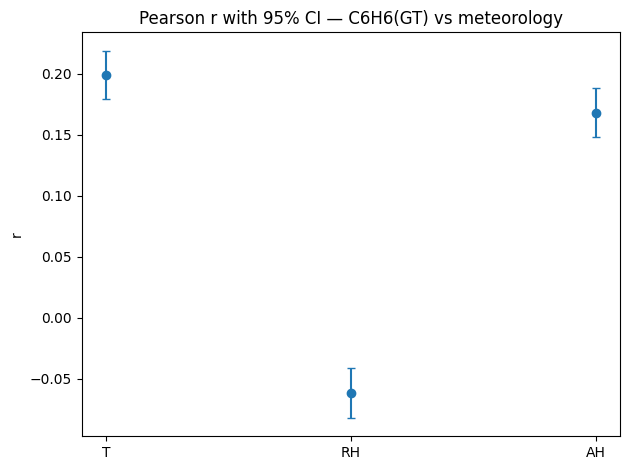

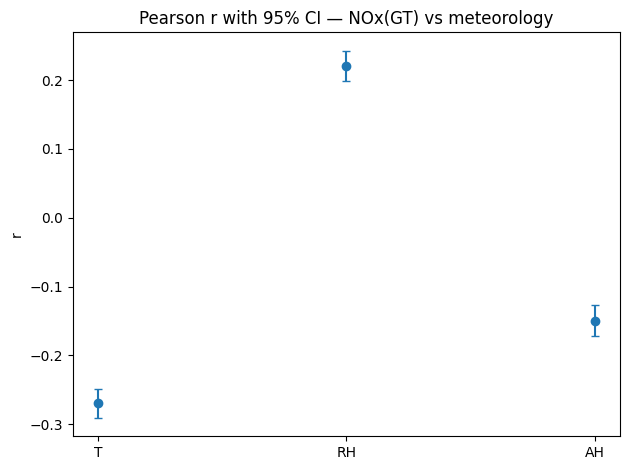

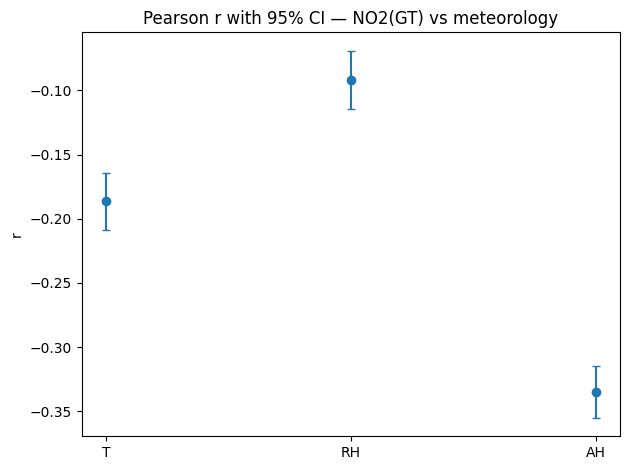

In [7]:

# 2) Confidence intervals with Fisher z (per pollutant)
for p in pollutant_cols:
    vals, lows, highs, labels = [], [], [], []
    for m in met_cols:
        a, b = pairwise_clean(df[m], df[p])
        r = corr_coef(a, b, method='pearson')
        lo, hi = fisher_ci(r, len(a))
        vals.append(r); lows.append(r-lo if not np.isnan(lo) else np.nan); highs.append(hi-r if not np.isnan(hi) else np.nan)
        labels.append(m)
    x = np.arange(len(labels)); yerr = [np.array(lows), np.array(highs)]
    plt.figure(); plt.errorbar(x, vals, yerr=yerr, fmt='o', capsize=3)
    plt.xticks(x, labels); plt.title(f'Pearson r with 95% CI — {p} vs meteorology')
    plt.ylabel('r'); plt.tight_layout(); plt.show()



=== Partial correlations (met ↔ pollutant | others) ===


pollutant,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
"T|RH,AH",0.065,0.004,0.090,0.007,0.035
"RH|T,AH",0.076,-0.086,0.048,0.105,0.018
"AH|T,RH",-0.047,0.152,-0.020,-0.075,-0.151


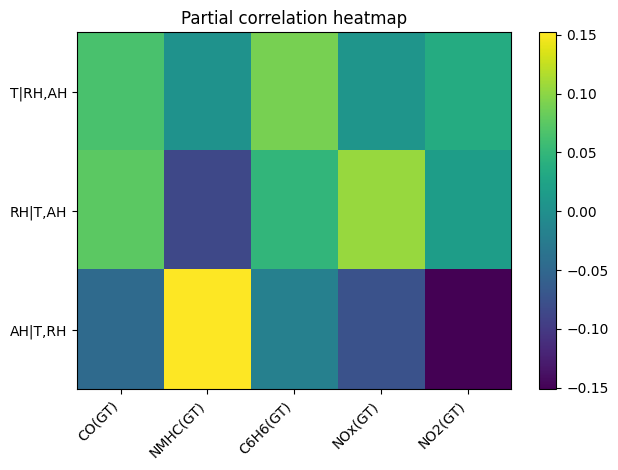

In [8]:

# 3) Partial correlations (control for other two meteorological vars)
rows = []
for p in pollutant_cols:
    # T | RH, AH
    r_t = partial_corr_xy_given_Z(df[[p] + met_cols], 'T', p, [v for v in met_cols if v != 'T']) if 'T' in met_cols else np.nan
    r_rh = partial_corr_xy_given_Z(df[[p] + met_cols], 'RH', p, [v for v in met_cols if v != 'RH']) if 'RH' in met_cols else np.nan
    r_ah = partial_corr_xy_given_Z(df[[p] + met_cols], 'AH', p, [v for v in met_cols if v != 'AH']) if 'AH' in met_cols else np.nan
    rows.append({'pollutant': p, 'T|RH,AH': r_t, 'RH|T,AH': r_rh, 'AH|T,RH': r_ah})
partial_df = pd.DataFrame(rows).set_index('pollutant').T
safe_display("Partial correlations (met ↔ pollutant | others)", partial_df.round(3))

plt.figure(); plt.imshow(partial_df.values, interpolation='nearest', aspect='auto')
plt.xticks(range(len(partial_df.columns)), partial_df.columns, rotation=45, ha='right')
plt.yticks(range(len(partial_df.index)), partial_df.index)
plt.title('Partial correlation heatmap'); plt.colorbar(); plt.tight_layout(); plt.show()


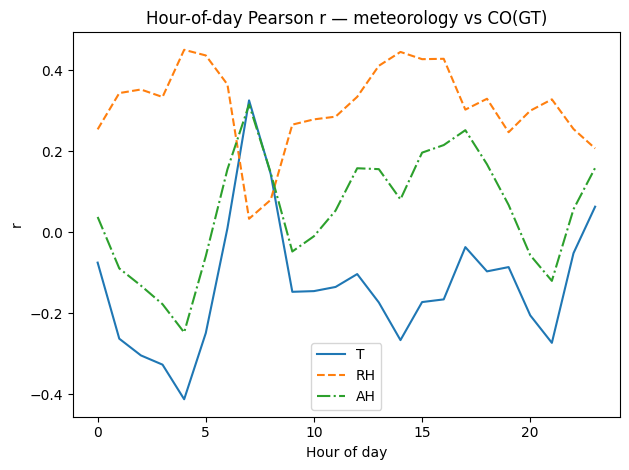

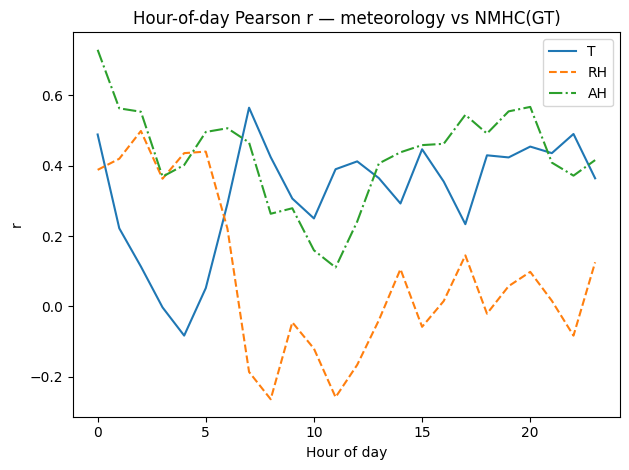

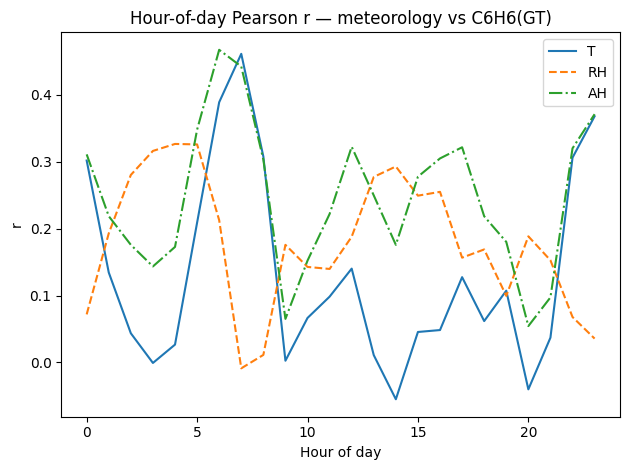

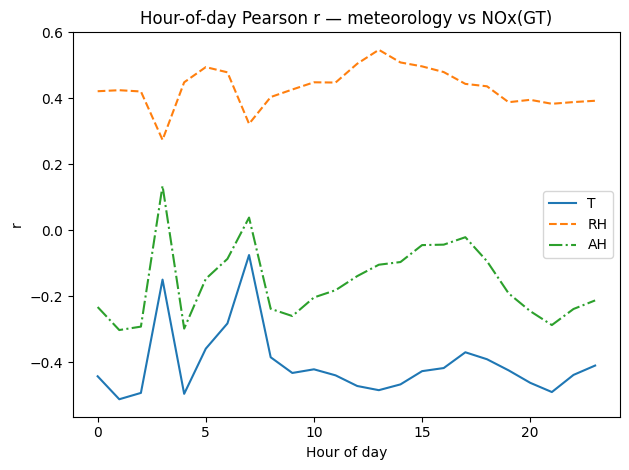

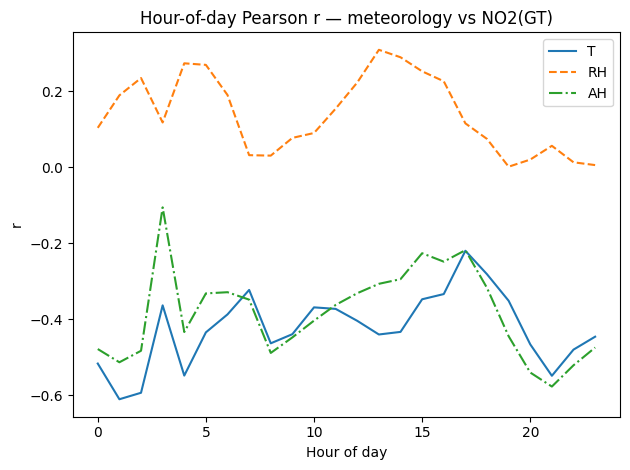

In [9]:

# 4) Hour-of-day correlations
for p in pollutant_cols:
    plt.figure()
    styles = ['-', '--', '-.']
    for i, m in enumerate(met_cols):
        series = hourly_corr(df[m], df[p], method='pearson')
        plt.plot(series.index.values, series.values, linestyle=styles[i % len(styles)], label=m)
    plt.title(f'Hour-of-day Pearson r — meteorology vs {p}')
    plt.xlabel('Hour of day'); plt.ylabel('r'); plt.legend(); plt.tight_layout(); plt.show()



=== Pearson correlation after deseasonalization ===


,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
T,0.055,0.255,0.150,-0.068,-0.029
RH,0.200,-0.002,0.138,0.204,0.007
AH,0.219,0.273,0.248,0.107,-0.053


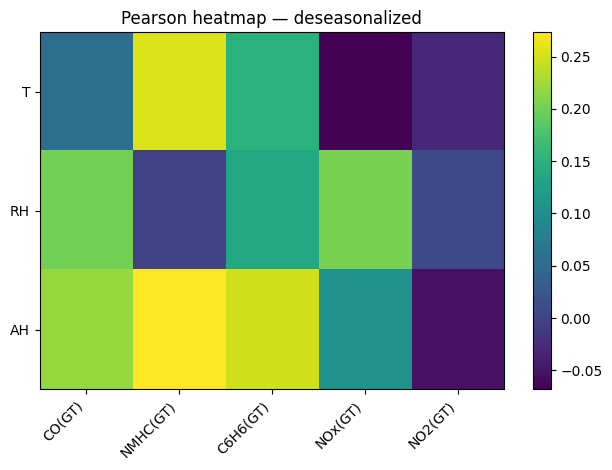

In [10]:

# 5) Deseasonalized correlations (remove hour + month cycles)
deseason_df = df.copy()
for col in pollutant_cols + met_cols:
    deseason_df[col] = deseason_hour_month(df[col])

pearson_deseason = build_corr_matrix(deseason_df, met_cols, pollutant_cols, method='pearson')
safe_display("Pearson correlation after deseasonalization", pearson_deseason.round(3))

plt.figure(); plt.imshow(pearson_deseason.values, interpolation='nearest', aspect='auto')
plt.xticks(range(len(pollutant_cols)), pollutant_cols, rotation=45, ha='right')
plt.yticks(range(len(met_cols)), met_cols)
plt.title('Pearson heatmap — deseasonalized'); plt.colorbar(); plt.tight_layout(); plt.show()


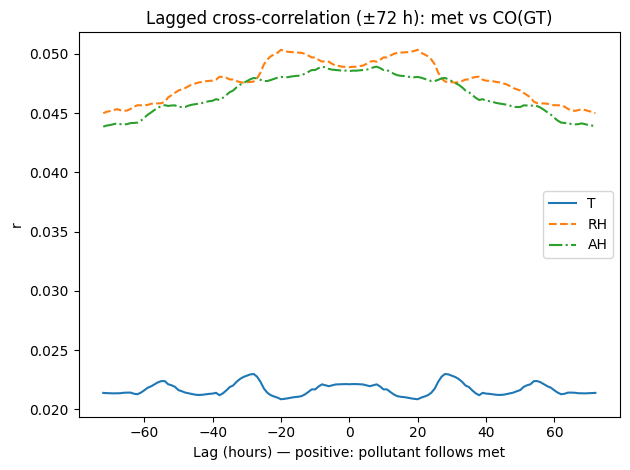

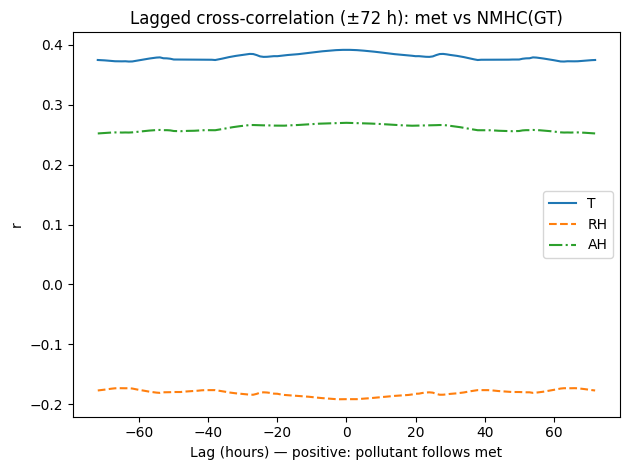

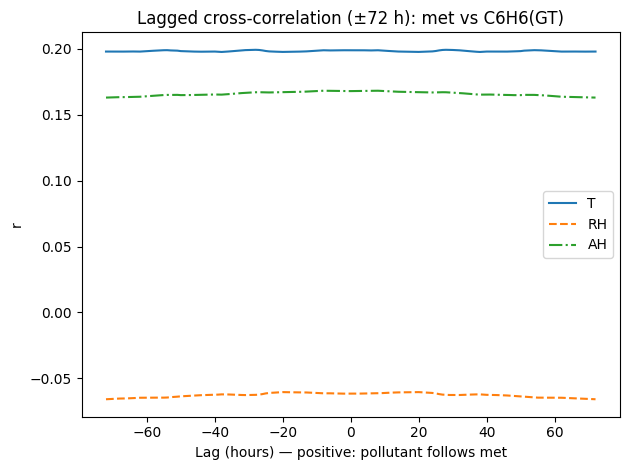

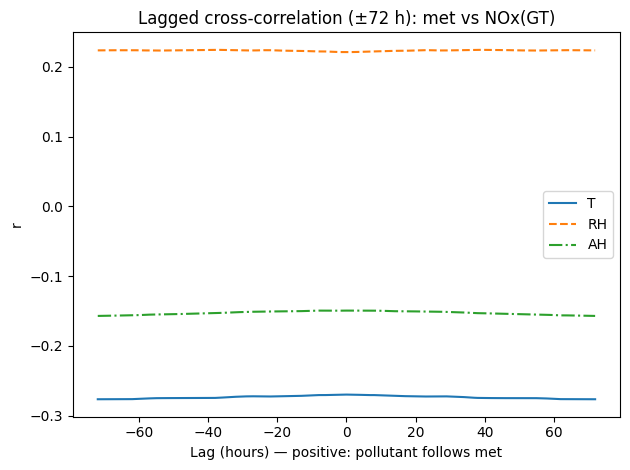

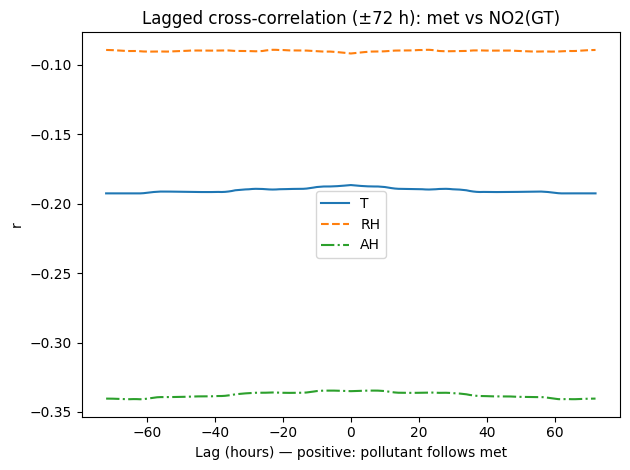

In [11]:

# 6) Lagged cross-correlations (±72 h)
for p in pollutant_cols:
    plt.figure()
    styles = ['-', '--', '-.']
    for i, m in enumerate(met_cols):
        lags, vals = crosscorr_series(df[m], df[p], max_lag=72)
        plt.plot(lags, vals, linestyle=styles[i % len(styles)], label=m)
    plt.title(f'Lagged cross-correlation (±72 h): met vs {p}')
    plt.xlabel('Lag (hours) — positive: pollutant follows met'); plt.ylabel('r')
    plt.legend(); plt.tight_layout(); plt.show()


/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


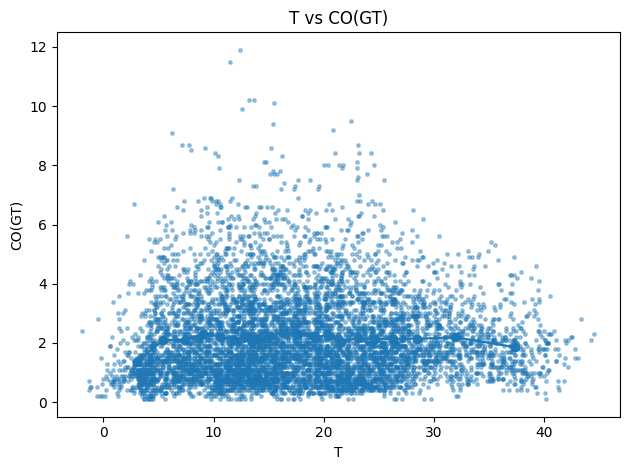

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


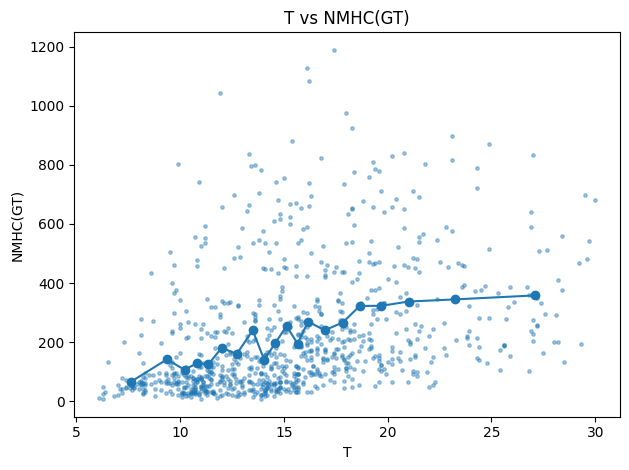

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


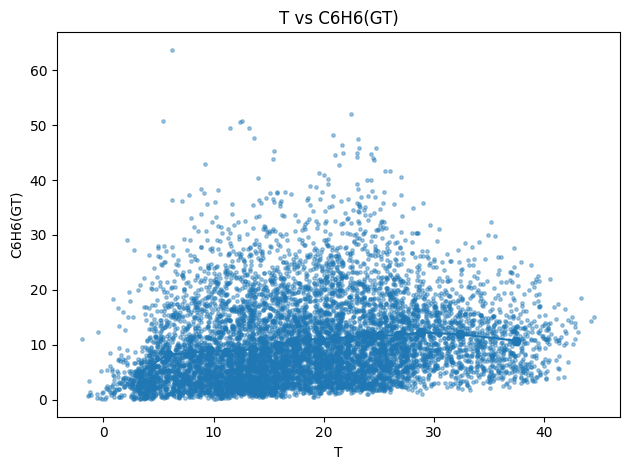

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


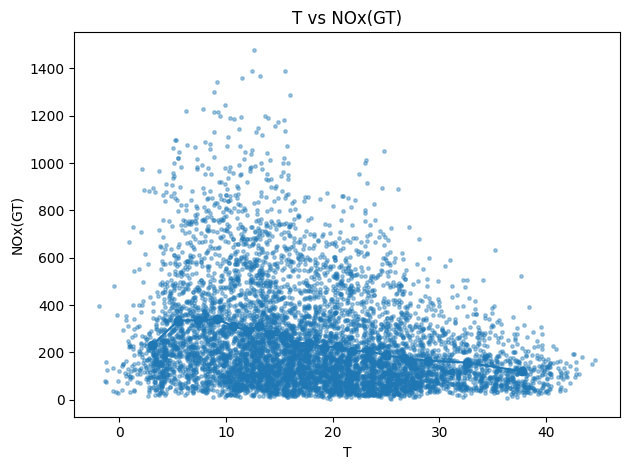

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


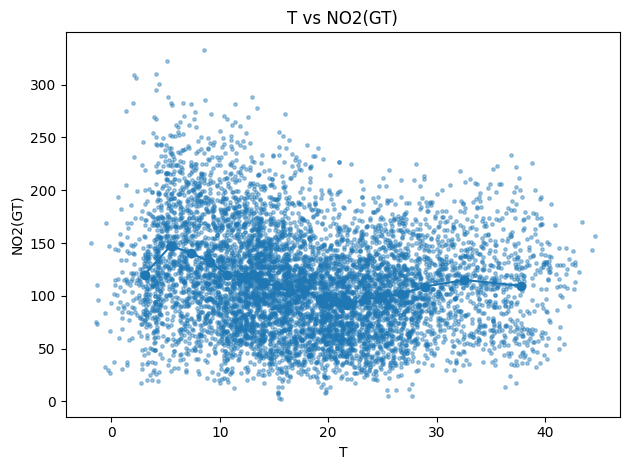

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


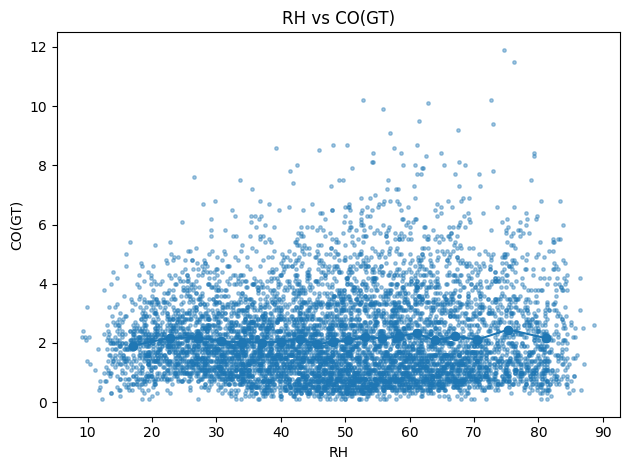

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


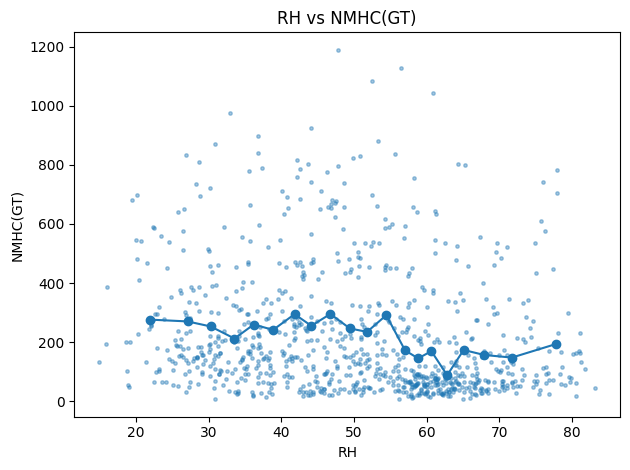

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


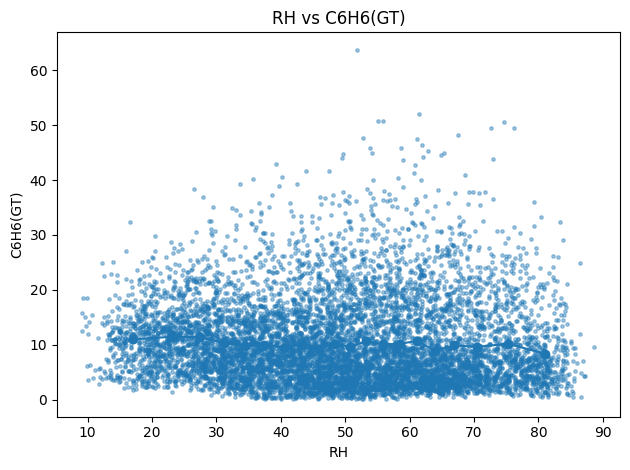

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


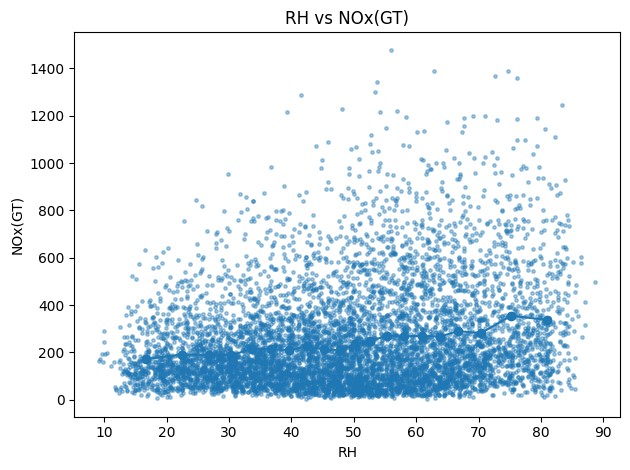

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


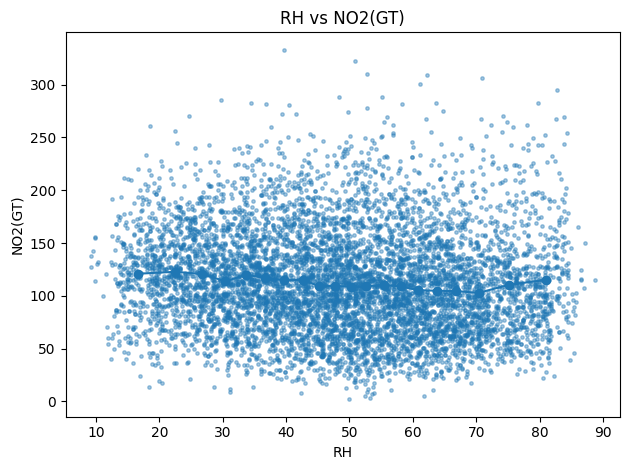

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


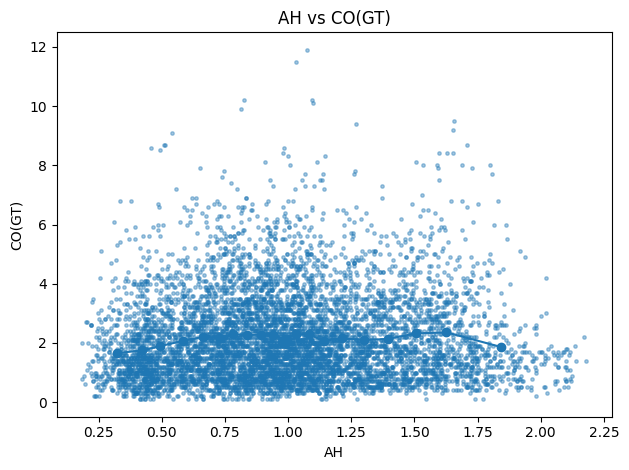

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


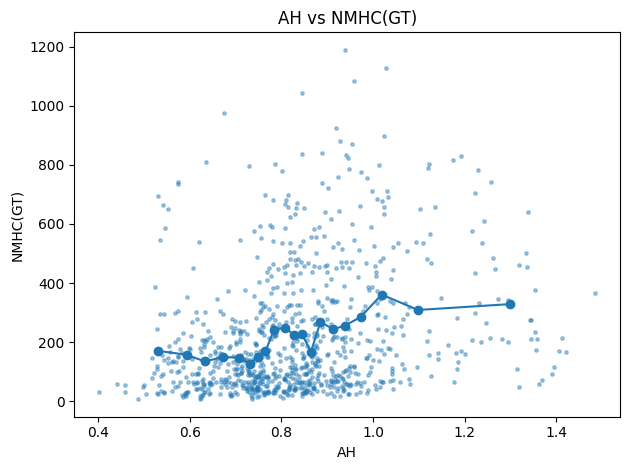

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


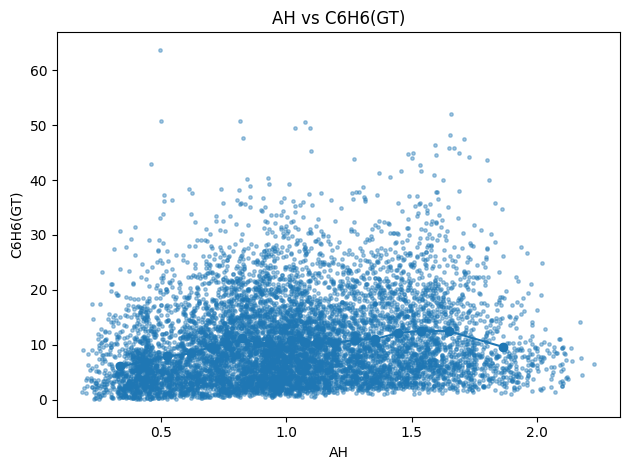

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


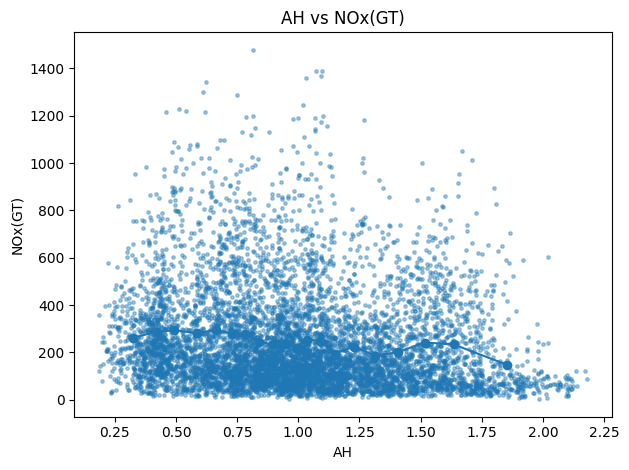

/tmp/ipykernel_193598/1732132100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))


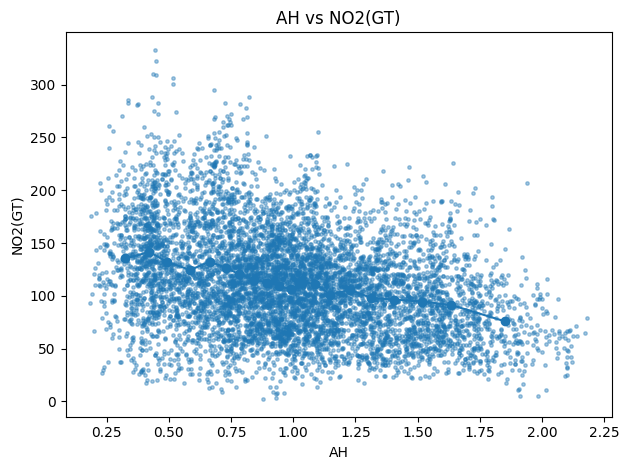

In [12]:

# 7) Scatter with binned trend overlays (every met × pollutant pair)
def scatter_with_binned_trend(x: pd.Series, y: pd.Series, xlab: str, ylab: str, title: str, q: int = 20):
    ab = pd.concat([x, y], axis=1).dropna()
    if ab.shape[0] == 0:
        return
    xv = ab.iloc[:,0].values; yv = ab.iloc[:,1].values
    plt.figure(); plt.scatter(xv, yv, s=6, alpha=0.4)
    try:
        bins = pd.qcut(ab.iloc[:,0], q=q, duplicates='drop')
        centers = ab.groupby(bins).apply(lambda d: pd.Series({'x_mean': d.iloc[:,0].mean(), 'y_mean': d.iloc[:,1].mean()}))
        plt.plot(centers['x_mean'].values, centers['y_mean'].values, linewidth=1.5, marker='o')
    except Exception:
        pass
    plt.xlabel(xlab); plt.ylabel(ylab); plt.title(title); plt.tight_layout(); plt.show()

for m in met_cols:
    for p in pollutant_cols:
        scatter_with_binned_trend(df[m], df[p], m, p, f'{m} vs {p}')
